Wrangling Bangladesh Time Series Data for downstream MICOM analysis

Input .biom table to convert to pandas df 

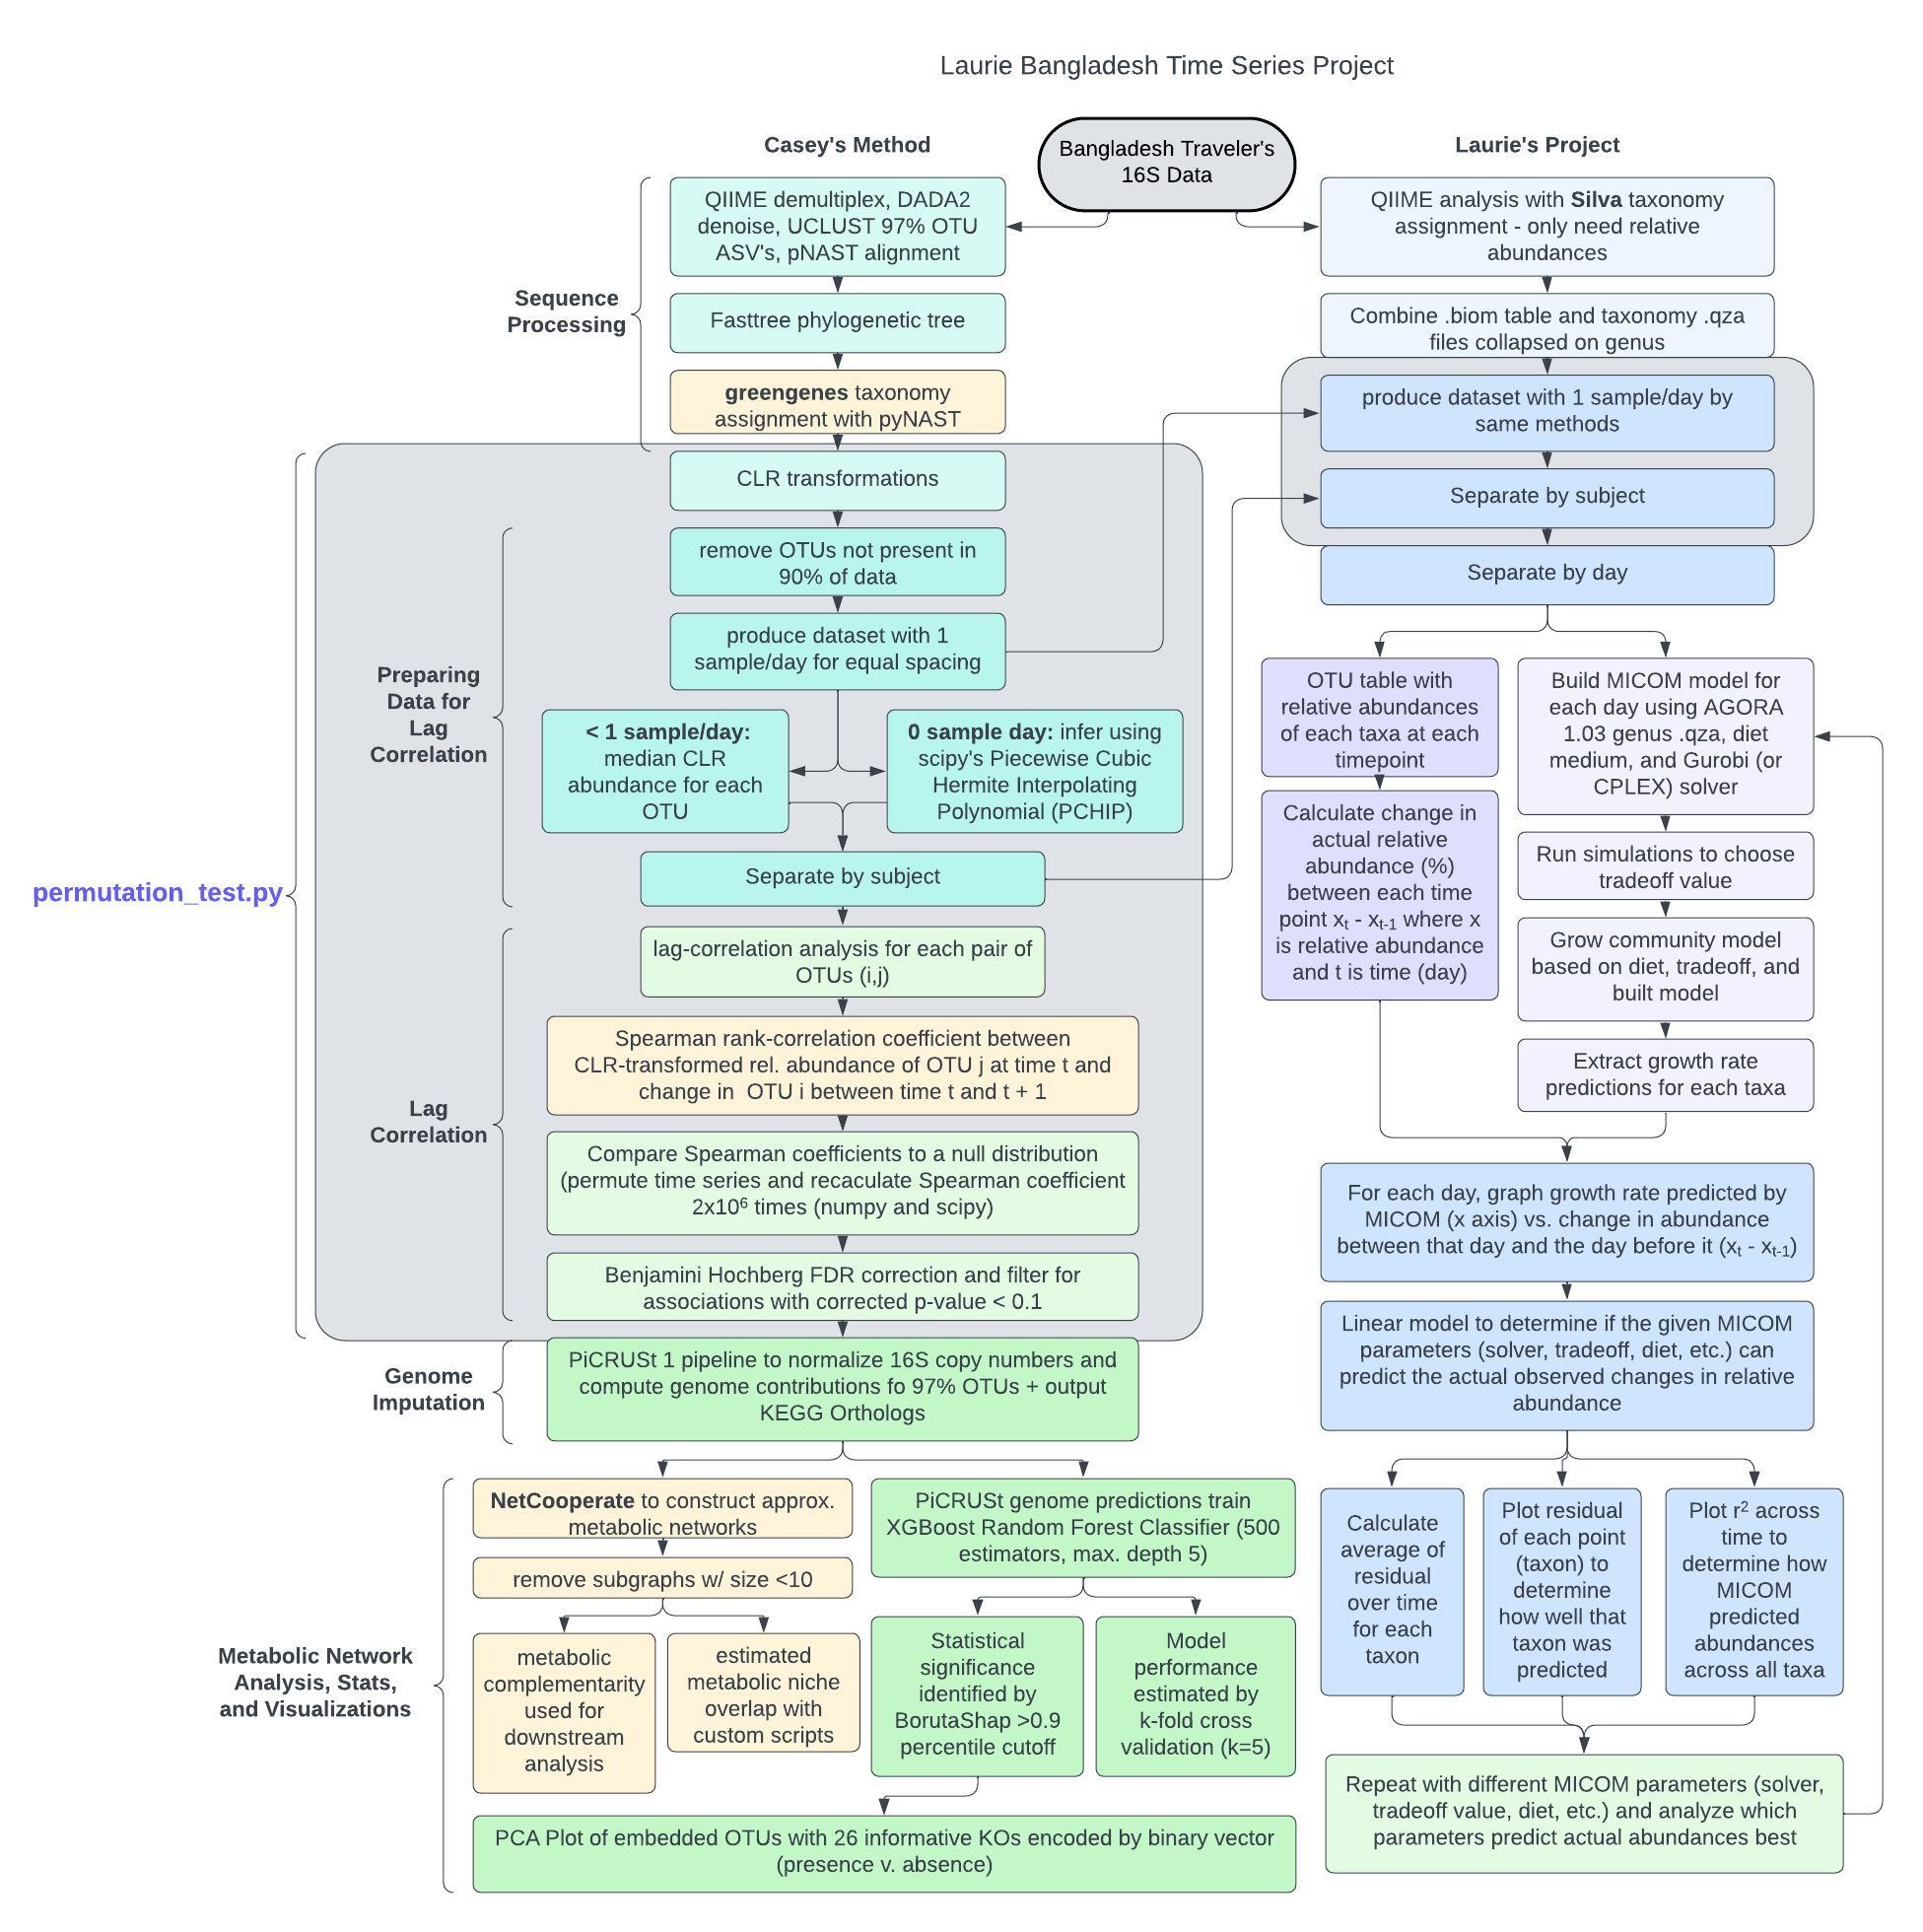

1) What files do I need to start with?
2) What do they need to look like to do the interpolation properly?

# Steps In Our Script:
  - Load in/Specify:
    - biom table
    - metadata
    - Subject ID (ANONYMIZED_NAME)
  - Convert biom table to pandas dataframe
  - Get the samples from the biom df & metadata associated from Subject N
  - If there are multiple samples in a day, take the average abundance for each OTU
    - see why this is not always working?
  - Generate all timepoints as if there were perfect daily sampling**
  - Figure out missing time points
  - Pass missing timepoints to interpolation function


  - take interpolated biom for each subject 
    - copy the rownames to a column in the df 
      - note: will have to pull rownames off after this since they are the epoch time and you don't want them to be the rownames anymore
    - convert that epoch time column back to actual dates 
    - use the actual dates to simulate sample ids (#SampleID column)
      - ex: 1015_actual_date_subject_Inter
      - after this you can pull the sample id column, the epoch time column, and the actual date columns out and save as variable for create new metadata file below
    - once you have sample id column, make the columns of otu table the sample ids and the rows the otu ids
      - note: may have to copy the otu ids to the new rownames prior to merge with raw data otu table 
    - from there you can merge them to the raw data otu table for that subject (merge on the left or the rownames, depending)
  - Combine interpolated biom dfs with real biom dfs for each subject.
    - **HINT** `pd.concat`
  - Create new metadata file that includes our synthetic samples
    - Will also need new column to specify if the timepoint was interpolated or not.
    - this is where your saved sample id column variable comes back in - you'll want to create a new data frame with those sample ids as well as a "data_type" column that states that they are interpolated samples 
  - Save outputs to directory

In [6]:
# Import required libraries
import biom
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
from pathlib import Path

# ---- Helper Functions ----

def biom2df(biom_table):
    """
    Converts a BIOM table into a pandas DataFrame.
    """
    # Extract the sparse matrix from the BIOM table
    data_matrix = biom_table.matrix_data.toarray()  # Convert sparse matrix to dense format
    
    # Convert the dense matrix into a pandas DataFrame
    df = pd.DataFrame(data_matrix, index=biom_table.ids(axis="observation"), columns=biom_table.ids(axis="sample"))
    return df


def meta_biom_filter(metadata, biom_df, anon_name, sample_col="#SampleID", subject_col="ANONYMIZED_NAME"):  
    """
    Filters metadata and BIOM table for a specific subject and OTU prevalence.

    Parameters:
    - metadata: Metadata as a pandas DataFrame.
    - biom_table: A BIOM-format table with microbial data.
    - anon_name: Subject ID to filter by.
    - filter_num: Minimum total abundance for an OTU to be retained.

    Returns:
    - Filtered metadata and a DataFrame of the filtered BIOM table.
    """
    # Set metadata row indices
    metadata.index = list(metadata[sample_col])
    subject_metadata = metadata[metadata[subject_col] == anon_name]

    # Align metadata and BIOM data based on shared indices
    shared_indices = list(set(subject_metadata[sample_col]) & set(biom_df.columns))
    subject_biom = biom_df[shared_indices]
    subject_metadata = subject_metadata.loc[shared_indices]

    return(subject_metadata, subject_biom)

def avg_sample_by_day(subject_metadata, subject_biom,
                      sample_col="#SampleID", time_col="epoch_time",
                      subject_col="ANONYMIZED_NAME"):
    """
    Calculates the mean abundance per OTU per day.

    Parameters:
      - subject_metadata (pd.DataFrame): Metadata for the samples, including time and subject information.
      - subject_biom (pd.DataFrame): OTU abundance table with sample IDs as columns.
      - sample_col (str): Column name for sample IDs in `subject_metadata`.
      - time_col (str): Column name for time points in `subject_metadata`.
      - subject_col (str): Column name for subject IDs in `subject_metadata`.

    Returns:
      - avg_subject_metadata (pd.DataFrame): Averaged metadata with one row per timepoint.
      - avg_day (pd.DataFrame): Mean OTU abundance per day.
    """
    # Ensure time_col is numeric for proper sorting and comparison
    subject_metadata[time_col] = subject_metadata[time_col].astype(int)
    
    # Extract unique sorted timepoints
    to_grab = [sample_col, time_col, subject_col]

    timepoints = sorted(subject_metadata[time_col].unique())

    # Initialize a DataFrame for average OTU abundance per day
    avg_day = []
    
    for day in timepoints:
        # Filter metadata for the current day
        daily_samples = subject_metadata.loc[subject_metadata[time_col] == day, sample_col]
        
        # Get mean OTU abundance for the daily samples
        avg_day.append(subject_biom[daily_samples].mean(axis=1))  # Mean along the sample axis

    # Create a DataFrame from the results
    avg_day = pd.DataFrame(avg_day, index=timepoints)

    # Create averaged metadata
    avg_subject_metadata = subject_metadata.groupby(time_col).first().reset_index()  # Retain the first entry per day

    avg_subject_metadata = avg_subject_metadata[to_grab]

    return avg_subject_metadata, avg_day

# Generate a range of dates 
# pandas.date_range function 
# want smallest and largest epoch time value in timepoints
def epoch_datetime_range(timepoints): 
    """
    Creates a range of dates in datetime from a list of ints in epoch time

    Parameters:
    - timepoints: a list of ints as epoch time

    Returns:
    - a list of ints in epoch time in one day intervals 
    """
    earliest = pd.to_datetime(min(timepoints), unit='s') #convert earliest timepoint to datetime
    latest = pd.to_datetime(max(timepoints), unit='s')

    date_range = pd.date_range(start= earliest, end=latest, freq='D')

    epoch_time_range = date_range.astype('int64') // 10**9 #convert datetime to epoch time, convert nanoseconds to seconds 

    return epoch_time_range


def missing_timepoints(epoch_time_range, timepoints):
    """ 
    Create a list of timepoints that are not present in a subject's timeseries

    Parameters: 
    - subject_date_range: 
    - avg_subject_meta["epoch_time"]: 

    Returns: 
    - a list of timepoints in epoch time 
    """
    # find set difference between timepoints and epoch_time_range 
    missing_times = list(set(epoch_time_range) - set(timepoints))

    return missing_times


def interp_missing_day(avg_subject_meta, avg_subject_biom):
    """
    Interpolates missing time points in a microbial community time series.
    """
    # Generate interpolator
    pchip = PchipInterpolator(avg_subject_biom.index, avg_subject_biom)

    # Generate full range of dates and find missing times
    subject_date_range = epoch_datetime_range(avg_subject_meta["epoch_time"])
    subject_missing_times = missing_timepoints(subject_date_range, avg_subject_meta["epoch_time"])

    # Ensure missing times are converted to a datetime object and floored to midnight UTC
    subject_missing_times = (
        pd.to_datetime(subject_missing_times, unit="s", utc=True)  # Convert to datetime
        .floor("D")  # Floor to midnight UTC
        .astype("int64") // 10**9  # Convert back to epoch time
    ).tolist()

    # Interpolate missing timepoints
    interp_biom = pchip(subject_missing_times)

    # Create DataFrame with interpolated values
    interp_biom = pd.DataFrame(
        interp_biom,
        index=subject_missing_times,
        columns=avg_subject_biom.columns
    )

    return interp_biom

In [ ]:
# Load BIOM table and metadata
myotubiom = biom.load_table("../data/dada2_otu_rare7500_lml.biom")
mymeta = pd.read_csv("../data/metadata_full_w_times.csv")
mybiom = biom2df(myotubiom)
subject_ids = ["F01", "M01", "M02"]
output_dir = "../data/interpolated_bioms/"
final_output_dir = "../data/combined_output/"

# Create directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(final_output_dir).mkdir(parents=True, exist_ok=True)

# Create dictionaries to store outputs
output_interp_bioms = {}
output_avg_subject_meta = {}
output_avg_subject_biom = {}

for subject in subject_ids: 
    # Filter metadata and BIOM table for each subject
    subject_metadata, subject_biom = meta_biom_filter(mymeta, mybiom, subject)
    avg_subject_meta, avg_subject_biom = avg_sample_by_day(subject_biom=subject_biom,
                                                           subject_metadata=subject_metadata)
    subject_interp_biom = interp_missing_day(avg_subject_meta, avg_subject_biom)

    # Save intermediate outputs to .csv files
    subject_interp_biom.to_csv(f"{output_dir}{subject}_interp_biom.csv")
    avg_subject_biom.to_csv(f"{output_dir}{subject}_avg_biom.csv")
    avg_subject_meta.to_csv(f"{output_dir}{subject}_avg_meta.csv")

    # Store outputs in dictionaries
    output_interp_bioms[subject] = subject_interp_biom
    output_avg_subject_meta[subject] = avg_subject_meta
    output_avg_subject_biom[subject] = avg_subject_biom

# Combine OTU tables for each subject and transpose for QIIME2
for subject in subject_ids:
    print(f"Combining and transposing OTU tables for subject {subject}...")

    # Retrieve real and interpolated OTU data
    avg_subject_biom = output_avg_subject_biom[subject]
    subject_interp_biom = output_interp_bioms[subject]

    # Concatenate real and interpolated OTU tables along rows
    combined_otu = pd.concat([avg_subject_biom, subject_interp_biom], axis=0)

    # Transpose the combined OTU table and rename the index column
    combined_otu_transposed = combined_otu.transpose()
    combined_otu_transposed.index.name = "#OTU ID"

    # Save the transposed OTU table as a .tsv file
    combined_otu_transposed.to_csv(f"{final_output_dir}{subject}_combined_otu_qiime2.tsv", sep="\t")

    print(f"Combined and transposed OTU table saved for subject {subject}.")

# Update metadata for each subject
for subject in subject_ids:
    print(f"Updating metadata for subject {subject}...")

    # Retrieve metadata
    avg_subject_meta = output_avg_subject_meta[subject]
    subject_interp_biom = output_interp_bioms[subject]

    # Create interpolated sample IDs
    interp_metadata = pd.DataFrame({
        "#SampleID": "1015_" + pd.to_datetime(subject_interp_biom.index, unit="s").floor("D").strftime("%m_%d") + f"_{subject}_interp",
        "epoch_time": subject_interp_biom.index,  # Retain the epoch_time column
        "ANONYMIZED_NAME": subject,
        "data_type": "Interpolated"
    })

    # Add "data_type" column to real metadata
    avg_subject_meta["data_type"] = "Real"

    # Combine real and interpolated metadata and sort by epoch time
    updated_metadata = pd.concat([avg_subject_meta, interp_metadata])
    updated_metadata = updated_metadata.sort_values(by="epoch_time")

    # Save updated metadata
    updated_metadata.to_csv(f"{final_output_dir}{subject}_updated_metadata.csv", index=False)

    print(f"Updated metadata saved for subject {subject}.")

In [2]:

# ---- Main Script ----

# Load BIOM table and metadata
myotubiom = biom.load_table("../data/dada2_otu_rare7500_lml.biom")
mymeta = pd.read_csv("../data/metadata_full_w_times.csv")
mybiom = biom2df(myotubiom)
subject_ids = ["F01", "M01", "M02"]
output_dir = "../data/interpolated_bioms/"
final_output_dir = "../data/combined_output/"

# create directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(final_output_dir).mkdir(parents=True, exist_ok=True)

## create an empty dictionary to store interpolated bioms
output_interp_bioms = {}
output_avg_subject_meta = {}
output_avg_subject_biom = {}

for subject in subject_ids: 

    # Filter metadata and BIOM table for subject "F01" 
    subject_metadata, subject_biom = meta_biom_filter(mymeta, mybiom, subject)
    avg_subject_meta, avg_subject_biom = avg_sample_by_day(subject_biom=subject_biom,
                                                subject_metadata=subject_metadata)

    subject_interp_biom = interp_missing_day(avg_subject_meta, avg_subject_biom)

    #save outputs to .csv files 
    subject_interp_biom.to_csv(f"{output_dir}{subject}_interp_biom.csv")
    avg_subject_biom.to_csv(f"{output_dir}{subject}_avg_biom.csv")
    avg_subject_meta.to_csv(f"{output_dir}{subject}_avg_meta.csv")

    
    ## add to dictionary with the label/key being the subject name and the value the interpolated biom
    output_interp_bioms.update({f"{subject}": subject_interp_biom})
    output_avg_subject_meta.update({f"{subject}": avg_subject_meta})
    output_avg_subject_biom.update({f"{subject}": avg_subject_biom})


In [ ]:
# Combine OTU tables for each subject
for subject in subject_ids:
    print(f"Combining OTU tables for subject {subject}...")

    # Retrieve real and interpolated OTU data
    avg_subject_biom = output_avg_subject_biom[subject]
    subject_interp_biom = output_interp_bioms[subject]

    # Concatenate real and interpolated OTU tables along rows
    combined_otu = pd.concat([avg_subject_biom, subject_interp_biom], axis=0)

    # Save the combined OTU table
    combined_otu.to_csv(f"{final_output_dir}{subject}_combined_otu.csv")

    print(f"Combined OTU table saved for subject {subject}.")

In [ ]:
# Update metadata for each subject
for subject in subject_ids:
    print(f"Updating metadata for subject {subject}...")

    # Retrieve metadata
    avg_subject_meta = output_avg_subject_meta[subject]
    subject_interp_biom = output_interp_bioms[subject]

    # Step 1: Create interpolated sample IDs
    # Convert epoch times to a human-readable format and generate sample IDs
    interp_metadata = pd.DataFrame({
        "#SampleID": "1015_" + pd.to_datetime(subject_interp_biom.index, unit="s").floor("D").strftime("%m_%d") + f"_{subject}_interp",
        "epoch_time": subject_interp_biom.index,  # Retain the epoch_time column
        "ANONYMIZED_NAME": subject,
        "data_type": "Interpolated"
    })

    # Step 2: Add "data_type" column to real metadata
    avg_subject_meta["data_type"] = "Real"

    # Step 3: Combine real and interpolated metadata and sort by sample ID
    updated_metadata = pd.concat([avg_subject_meta, interp_metadata])
    updated_metadata = updated_metadata.sort_values(by="epoch_time")

    # Step 4: Save updated metadata
    updated_metadata.to_csv(f"{final_output_dir}{subject}_updated_metadata.csv", index=False)

    print(f"Updated metadata saved for subject {subject}.")

# QIIME compatability
  - what format foes otu table need to be in for qiime2?
  - currently have epoch time as index for rows and OTUs as columns 


Added this and a parser to introduce arguments (see ```time_series_data_wrangling_w_parser.py```)

```bash
python process_otu_metadata.py \
  -n "../data/dada2_otu_rare7500_lml.biom" \
  -m "../data/metadata_full_w_times.csv" \
  -i "../data/interpolated_bioms/" \
  -o "../data/combined_output/" \
  -l F01 M01 M02
```

## what each argument does 
1.	-n or --input_biom_path: Path to the input BIOM file.
2.	-m or --metadata_path: Path to the metadata file.
3.	-i or --output_dir: Directory where intermediate files (e.g., interpolated OTU tables) will be saved.
4.	-o or --final_output_dir: Directory where final combined outputs will be saved.
5.	-l or --subject_ids: List of subject IDs to process.

In [12]:
# Run the script with the required arguments
%run ../scripts/time_series_data_wrangling_w_parser.py \
  -i "../data/dada2_otu_rare7500_lml.biom" \
  -m "../data/metadata_full_w_times.csv" \
  -n "../data/interpolated_bioms/" \
  -o "../data/combined_meta_and_otu_outputs/" \
  -l F01 M01 M02

Loading BIOM table and metadata...
Processing data for subject F01...
Processing data for subject M01...
Processing data for subject M02...
Combining and transposing OTU tables for subject F01...
Combining and transposing OTU tables for subject M01...
Combining and transposing OTU tables for subject M02...
Updating metadata for subject F01...
Updating metadata for subject M01...
Updating metadata for subject M02...
